In [1]:
!pip install insightface opencv-python imagehash umap-learn scikit-learn matplotlib numpy pandas tqdm pillow

  Using cached insightface-0.7.3.tar.gz (439 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached opencv_python-4.12.0.88-cp37-abi3-macosx_13_0_arm64.whl.metadata (19 kB)
  Using cached scikit_learn-1.7.2-cp313-cp313-macosx_12_0_arm64.whl.metadata (11 kB)
  Using cached numpy-2.3.3-cp313-cp313-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached pandas-2.3.3-cp313-cp313-macosx_11_0_arm64.whl.metadata (91 kB)
  Using cached pillow-11.3.0-cp313-cp313-macosx_11_0_arm64.whl.metadata (9.0 kB)
  Using cached scipy-1.16.2-cp313-cp313-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached scikit_image-0.25.2-cp313-cp313-macosx_12_0_arm64.whl.metadata (14 kB)
  Using cached easydict-1.13-py3-none-any.whl.metadata (4.2 kB)
  Using cached cython-3.1.4-cp313-cp313-macosx_11_0_arm64.whl.metadata (5.0 kB)
  Using cached albumentations-2.0.8-py3-none-any.whl.metadata (43 kB)
  Using cached prettytable

Setups + Deps

In [3]:

import os, math, json, hashlib, itertools, warnings
from pathlib import Path
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import imagehash

# InsightFace (detector + 5pt landmarks + embeddings)
from insightface.app import FaceAnalysis

plt.rcParams["figure.dpi"] = 140
warnings.filterwarnings("ignore")

DATA_ROOT = Path("data/raw")      # <- your per-ID folders are already here
OUT_ROOT  = Path("runs/eda"); OUT_ROOT.mkdir(parents=True, exist_ok=True)


Scan Files + Integrity

In [4]:
def list_images(root: Path):
    rows = []
    for cls in sorted(root.iterdir()):
        if not cls.is_dir(): continue
        for p in cls.rglob("*"):
            if p.suffix.lower() in {".jpg",".jpeg",".png"}:
                rows.append({"path": str(p), "id": cls.name})
    df = pd.DataFrame(rows)
    print(f"found {len(df)} images across {df['id'].nunique()} identities")
    return df

def file_md5(p: Path) -> str:
    h = hashlib.md5()
    with open(p, "rb") as f:
        for chunk in iter(lambda: f.read(1<<20), b""): h.update(chunk)
    return h.hexdigest()

df = list_images(DATA_ROOT)
df["exists"] = df["path"].apply(lambda p: Path(p).exists())
df = df[df["exists"]].drop(columns=["exists"]).reset_index(drop=True)

# openability + mode + size
rows = []
for i, row in tqdm(df.iterrows(), total=len(df), desc="integrity"):
    p = Path(row["path"])
    try:
        with Image.open(p) as im:
            im.load()
            rows.append({
                "path": row["path"],
                "id": row["id"],
                "width": im.width, "height": im.height, "mode": im.mode,
                "filesize": p.stat().st_size
            })
    except Exception as e:
        print("bad image:", p, e)
integrity = pd.DataFrame(rows)
integrity.to_csv(OUT_ROOT/"integrity.csv", index=False)
integrity.head()

found 40709 images across 247 identities


integrity: 100%|██████████| 40709/40709 [00:08<00:00, 4903.89it/s]


,path,id,width,height,mode,filesize
0,data/raw/ABHAY/ABHAY_4.jpeg,ABHAY,64,64,RGB,2250
1,data/raw/ABHAY/ABHAY_12.jpeg,ABHAY,371,371,RGB,40563
2,data/raw/ABHAY/ABHAY_8.jpeg,ABHAY,261,261,RGB,25988
3,data/raw/ABHAY/ABHAY_9.jpeg,ABHAY,201,201,RGB,18933
4,data/raw/ABHAY/ABHAY_13.jpeg,ABHAY,215,215,RGB,19751


Duplicates (exact)

In [5]:
# ==== EXACT DUPLICATES ONLY (MD5) ====
from pathlib import Path
import hashlib, pandas as pd

def file_md5(p: Path) -> str:
    h = hashlib.md5()
    with open(p, "rb") as f:
        for chunk in iter(lambda: f.read(1<<20), b""): h.update(chunk)
    return h.hexdigest()

print("computing md5 (exact dupes)…")
integrity["md5"] = integrity["path"].apply(lambda p: file_md5(Path(p)))

dup_groups = (
    integrity.groupby("md5")
    .agg(paths=("path", list),
         ids=("id", lambda s: list(sorted(set(s)))),
         n=("path","count"))
    .reset_index()
)

# any md5 that appears >1 -> exact duplicates
exact_dups = dup_groups[dup_groups["n"] > 1].copy()
same_id_dups  = exact_dups[exact_dups["ids"].apply(len) == 1]
cross_id_dups = exact_dups[exact_dups["ids"].apply(len) > 1]

exact_dups.to_json(OUT_ROOT/"exact_duplicates.json", orient="records", indent=2)
same_id_dups.to_json(OUT_ROOT/"exact_dupes_same_id.json", orient="records", indent=2)
cross_id_dups.to_json(OUT_ROOT/"exact_dupes_cross_id.json", orient="records", indent=2)

print(f"exact duplicate groups: {len(exact_dups)} "
      f"(same-id: {len(same_id_dups)}, cross-id: {len(cross_id_dups)})")

computing md5 (exact dupes)…
exact duplicate groups: 271 (same-id: 271, cross-id: 0)


Class Balance + Sizes + Quality Metrics

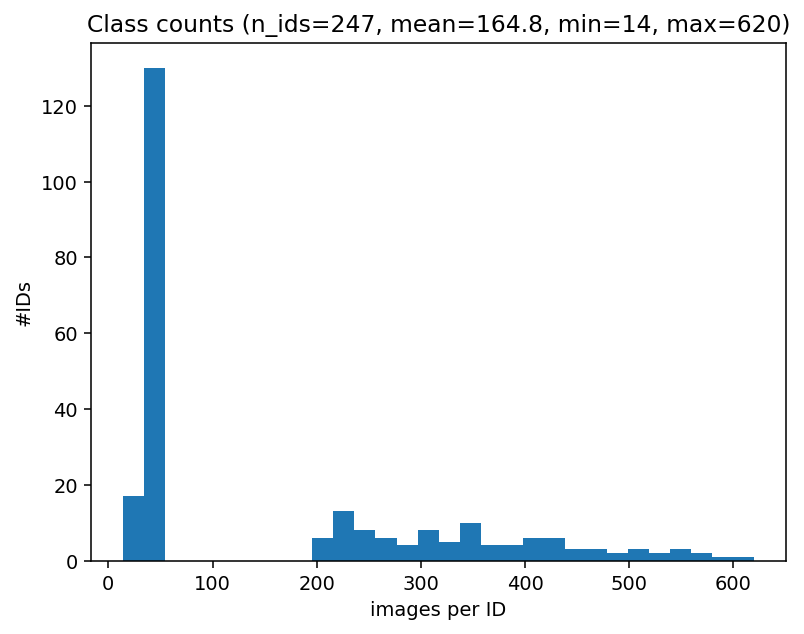

quality: 100%|██████████| 40709/40709 [00:13<00:00, 3129.28it/s]


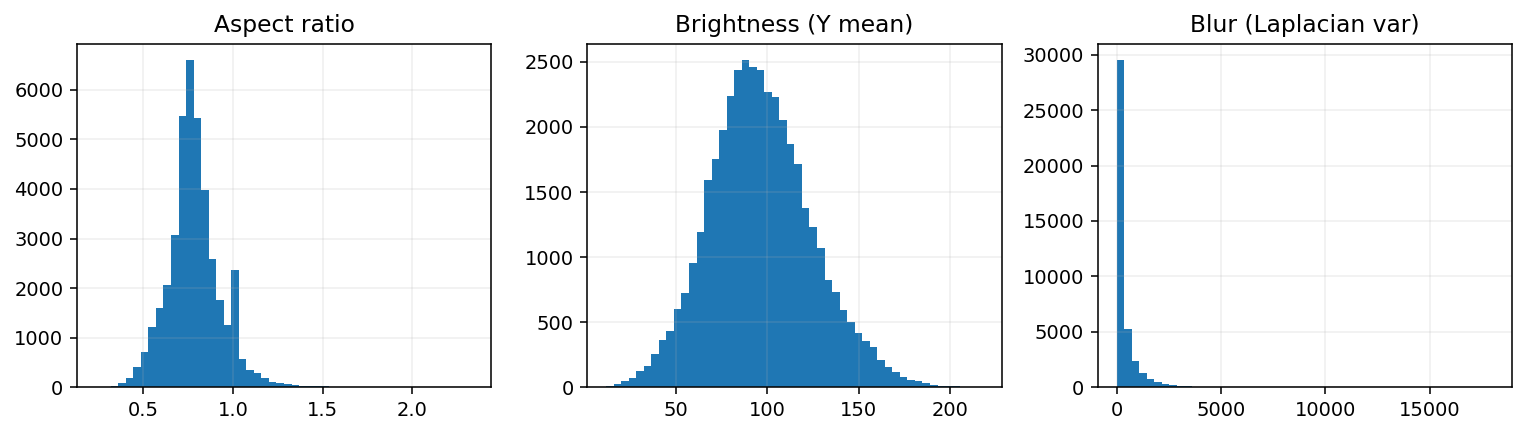

In [6]:
# class counts
counts = integrity.groupby("id")["path"].count().sort_values(ascending=False)
counts.to_csv(OUT_ROOT/"class_counts.csv")
plt.figure()
plt.hist(counts.values, bins=min(30, max(5, len(counts)//2)))
plt.xlabel("images per ID"); plt.ylabel("#IDs")
plt.title(f"Class counts (n_ids={len(counts)}, mean={counts.mean():.1f}, min={counts.min()}, max={counts.max()})")
plt.savefig(OUT_ROOT/"class_counts.png", bbox_inches="tight"); plt.show()

# geometry + quality proxies
def load_bgr(p):
    x = cv2.imdecode(np.fromfile(p, dtype=np.uint8), cv2.IMREAD_COLOR)  # handles unicode paths
    if x is None: x = cv2.imread(p)
    return x

metrics = []
for p in tqdm(integrity["path"].tolist(), desc="quality"):
    img = load_bgr(p)
    if img is None: continue
    h, w = img.shape[:2]
    ycc = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    Y = ycc[...,0]
    lum_mean = float(np.mean(Y))
    lum_std  = float(np.std(Y))
    blur_var = float(cv2.Laplacian(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), cv2.CV_64F).var())
    size_bytes = Path(p).stat().st_size
    metrics.append({
        "path": p, "id": Path(p).parent.name,
        "width": w, "height": h, "aspect": w/(h+1e-9),
        "lum_mean": lum_mean, "lum_std": lum_std,
        "blur_var": blur_var,
        "bytes_per_mp": size_bytes / max(1, (w*h)/1e6)
    })
metrics = pd.DataFrame(metrics)
metrics.to_csv(OUT_ROOT/"image_metrics.csv", index=False)

# plots
fig, axs = plt.subplots(1,3, figsize=(11,3.2))
axs[0].hist(metrics["aspect"], bins=50); axs[0].set_title("Aspect ratio")
axs[1].hist(metrics["lum_mean"], bins=50); axs[1].set_title("Brightness (Y mean)")
axs[2].hist(metrics["blur_var"], bins=50); axs[2].set_title("Blur (Laplacian var)")
for ax in axs: ax.grid(alpha=.2)
plt.tight_layout(); plt.savefig(OUT_ROOT/"quality_hists.png", bbox_inches="tight"); plt.show()

In [11]:
def tile(paths, out, cols=8, thumb=160):
    if not paths:  # <-- guard
        print(f"[tile] no images for {out}, skipping")
        return
    rows = math.ceil(len(paths)/cols)
    rows = max(rows, 1)
    canvas = Image.new("RGB", (cols*thumb, rows*thumb), (240,240,240))
    for i,p in enumerate(paths):
        try:
            im = Image.open(p).convert("RGB").resize((thumb, thumb))
            x=(i%cols)*thumb; y=(i//cols)*thumb
            canvas.paste(im, (x,y))
        except Exception as e:
            pass
    canvas.save(out)


# 12 darkest / brightest / blurriest
darkest = metrics.sort_values("lum_mean").head(12)["path"].tolist()
brightest= metrics.sort_values("lum_mean").tail(12)["path"].tolist()
blurriest= metrics.sort_values("blur_var").head(12)["path"].tolist()
tile(darkest,  OUT_ROOT/"darkest.jpg")
tile(brightest,OUT_ROOT/"brightest.jpg")
tile(blurriest,OUT_ROOT/"blurriest.jpg")

Face Detection Coverage + landmarks/yaw proxy

In [8]:
det = FaceAnalysis(name="buffalo_l")
# CPU is fine; set ctx_id=-1. If you have GPU, use 0.
det.prepare(ctx_id=-1, det_size=(640,640))

rows=[]
for p in tqdm(integrity["path"].tolist(), desc="detect"):
    img = load_bgr(p)
    if img is None:
        rows.append({"path": p, "id": Path(p).parent.name, "faces": 0})
        continue
    faces = det.get(img)
    n = len(faces)
    best = None
    if n>0:
        best = max(faces, key=lambda f: getattr(f, "det_score", 0.0))
        x1,y1,x2,y2 = best.bbox.astype(int)
        fa = (x2-x1)*(y2-y1) / (img.shape[0]*img.shape[1])
        score = float(getattr(best,"det_score",0.0))

        # yaw proxy from left/right eye distances to nose (approximate)
        # kps order: right_eye, left_eye, nose, right_mouth, left_mouth
        kps = best.kps
        re, le, no = kps[0], kps[1], kps[2]
        d_re = np.linalg.norm(re - no)
        d_le = np.linalg.norm(le - no)
        yaw_proxy = float(d_re - d_le)  # >0 means looking slightly to left

        rows.append({"path": p, "id": Path(p).parent.name,
                     "faces": n, "det_score": score, "bbox_frac": fa,
                     "yaw_proxy": yaw_proxy})
    else:
        rows.append({"path": p, "id": Path(p).parent.name, "faces": 0,
                     "det_score": 0.0, "bbox_frac": 0.0, "yaw_proxy": 0.0})
faces_df = pd.DataFrame(rows)
faces_df.to_csv(OUT_ROOT/"faces_detect.csv", index=False)

# coverage by ID
cov = faces_df.groupby("id").apply(lambda g: pd.Series({
    "images": len(g), "detected": int((g["faces"]>0).sum()),
    "coverage": float((g["faces"]>0).mean()),
    "bbox_frac_mean": float(g.loc[g["faces"]>0, "bbox_frac"].mean())
})).reset_index()
cov.to_csv(OUT_ROOT/"coverage_per_id.csv", index=False)
cov.sort_values("coverage").head(10)

download_path: /Users/Agriya/.insightface/models/buffalo_l


100%|██████████| 281857/281857 [00:14<00:00, 19048.45KB/s]


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/Agriya/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/Agriya/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/Agriya/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/Agriya/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/Agriya/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127

detect: 100%|██████████| 40709/40709 [51:00<00:00, 13.30it/s] 


,id,images,detected,coverage,bbox_frac_mean
0,ABHAY,14.0,0.0,0.0,NaN
153,irrfan_khan,47.0,0.0,0.0,NaN
155,jeetendra,46.0,0.0,0.0,NaN
156,jimmy_sheirgill,46.0,0.0,0.0,NaN
157,johnny_lever,47.0,0.0,0.0,NaN
158,kader_khan,44.0,0.0,0.0,NaN
159,kalki_koechlin,48.0,0.0,0.0,NaN
160,kamal_haasan,48.0,0.0,0.0,NaN
161,kangana_ranaut,45.0,0.0,0.0,NaN
162,kay_kay_menon,45.0,0.0,0.0,NaN


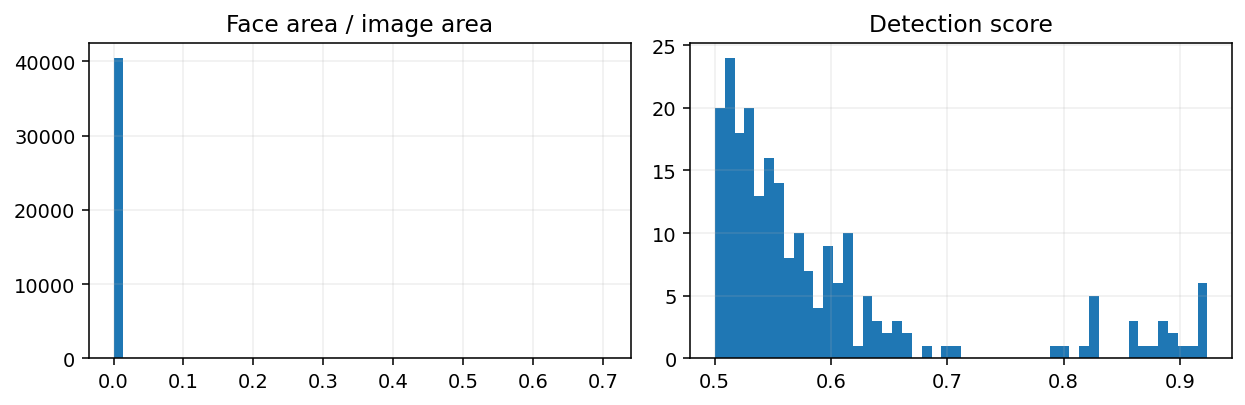

In [9]:
plt.figure(figsize=(9,3))
plt.subplot(1,2,1); plt.hist(faces_df["bbox_frac"], bins=50); plt.title("Face area / image area"); plt.grid(alpha=.2)
plt.subplot(1,2,2); plt.hist(faces_df.loc[faces_df["faces"]>0, "det_score"], bins=50); plt.title("Detection score"); plt.grid(alpha=.2)
plt.tight_layout(); plt.savefig(OUT_ROOT/"det_coverage_hists.png", bbox_inches="tight"); plt.show()

In [12]:
def sample_paths(df, cond, k=20):
    s = df[cond]["path"].tolist()
    return s[:k] if len(s)>=k else s

no_face   = sample_paths(faces_df, faces_df["faces"]==0, 36)
tiny_face = sample_paths(faces_df, (faces_df["faces"]>0) & (faces_df["bbox_frac"]<0.05), 36)
low_score = sample_paths(faces_df, (faces_df["faces"]>0) & (faces_df["det_score"]<0.4), 36)

tile(no_face,   OUT_ROOT/"bad_no_face.jpg",   cols=9, thumb=128)
tile(tiny_face, OUT_ROOT/"bad_tiny_face.jpg", cols=9, thumb=128)
tile(low_score, OUT_ROOT/"bad_low_score.jpg", cols=9, thumb=128)

[tile] no images for runs/eda/bad_low_score.jpg, skipping


Embedding-Space Sanity: intra vs inter, NN Violations

embeddings: 100%|██████████| 40709/40709 [1:09:15<00:00,  9.80it/s]    


embeddings computed: 224  /  40709


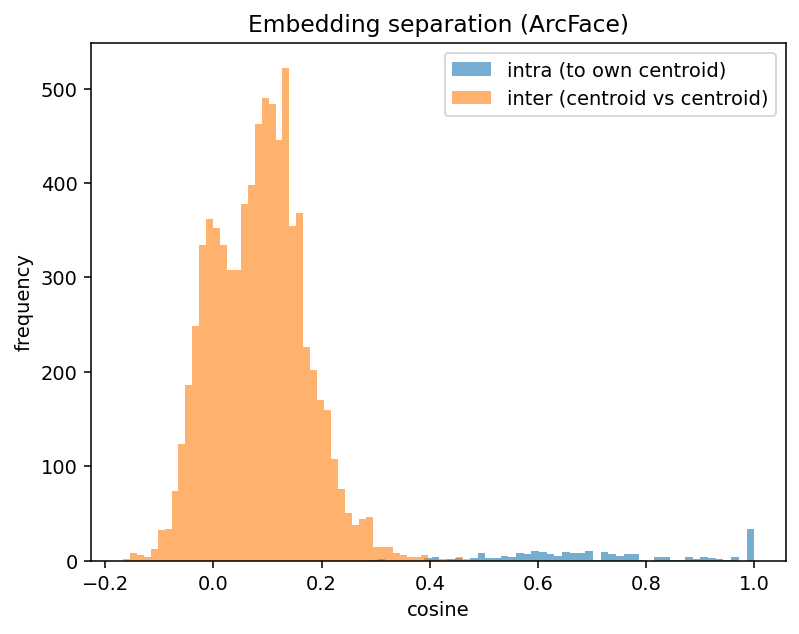

NN violations: 177


In [15]:
# use same app but we only need embeddings from best face per image
rows=[]
for p,idname in tqdm(zip(faces_df["path"], faces_df["id"]), total=len(faces_df), desc="embeddings"):
    img = load_bgr(p)
    faces = det.get(img) if img is not None else []
    if not faces:
        rows.append({"path": p, "id": idname, "ok": 0})
        continue
    f = max(faces, key=lambda f: getattr(f,"det_score",0.0))
    emb = f.normed_embedding  # 512-D, already L2-normalized
    rows.append({"path": p, "id": idname, "ok": 1, "emb": emb})
emb_df = pd.DataFrame(rows)
emb_df_ok = emb_df[emb_df["ok"]==1].copy()
print("embeddings computed:", len(emb_df_ok), " / ", len(emb_df))

# centroids
centroids = emb_df_ok.groupby("id")["emb"].apply(lambda E: np.mean(np.vstack(E.values), axis=0))
ids = sorted(centroids.index.tolist())
C = np.vstack([centroids[i] for i in ids])  # [C,512]

# intra-class cosines (to own centroid)
def cosine(a, b):
    return float(np.dot(a,b) / (np.linalg.norm(a)*np.linalg.norm(b) + 1e-9))

intra = []
for _, r in emb_df_ok.iterrows():
    intra.append(cosine(r["emb"], centroids[r["id"]]))
intra = np.array(intra)

# inter-class centroid cosines
M = C @ C.T
np.fill_diagonal(M, np.nan)
inter = M[~np.isnan(M)].ravel()

# plot densities
plt.figure()
plt.hist(intra, bins=50, alpha=.6, label="intra (to own centroid)")
plt.hist(inter, bins=50, alpha=.6, label="inter (centroid vs centroid)")
plt.legend(); plt.xlabel("cosine"); plt.ylabel("frequency")
plt.title("Embedding separation (ArcFace)")
plt.savefig(OUT_ROOT/"intra_inter_cosine.png", bbox_inches="tight"); plt.show()

# nearest neighbor violations
E = np.vstack(emb_df_ok["emb"].values)         # [N,512]
Y = emb_df_ok["id"].values
S = E @ E.T                                    # cosine (since L2-normed)
np.fill_diagonal(S, -np.inf)
nn_idx = np.argmax(S, axis=1)
nn_id  = Y[nn_idx]
viol = emb_df_ok[nn_id != Y].copy()
viol["nn_id"] = nn_id[nn_id != Y]
viol[["path","id","nn_id"]].to_csv(OUT_ROOT/"nn_violations.csv", index=False)
print("NN violations:", len(viol))

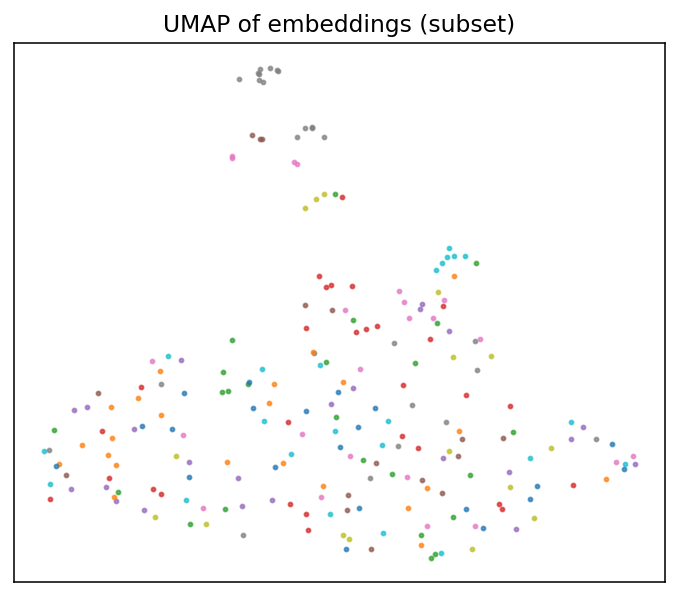

In [16]:
# !pip install umap-learn
import umap
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric="cosine", random_state=42)
Z = reducer.fit_transform(E)
plt.figure(figsize=(6,5))
for k in np.unique(Y):
    idx = np.where(Y==k)[0]
    plt.scatter(Z[idx,0], Z[idx,1], s=4, label=k, alpha=0.7)
plt.xticks([]); plt.yticks([]); plt.title("UMAP of embeddings (subset)")
plt.savefig(OUT_ROOT/"umap_embeddings.png", bbox_inches="tight"); plt.show()

Leakage-safe Splits

In [14]:
# ==== SPLIT BY CLUSTERS USING MD5 (exact dupes) ====
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

# Use only images that passed integrity check
df_ok = integrity.copy()

# Each unique md5 == cluster; images sharing an md5 must not cross splits
df_ok["cluster"] = df_ok["md5"]

# Collapse to one representative per cluster for stratified splitting
rep_by_cluster = {}
for _, r in df_ok.iterrows():
    c = r["cluster"]
    if c not in rep_by_cluster:
        rep_by_cluster[c] = (r["path"], r["id"])
reps = pd.DataFrame([{"path":p, "id":i, "cluster":c}
                     for c,(p,i) in rep_by_cluster.items()])

# 80/20 trainval/test by identity
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
trainval_idx, test_idx = next(sss.split(reps["path"], reps["id"]))
trainval, test = reps.iloc[trainval_idx], reps.iloc[test_idx]

# 75/25 of trainval -> train/val  (=> 60/20/20 overall)
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
tr_idx, val_idx = next(sss2.split(trainval["path"], trainval["id"]))
train, val = trainval.iloc[tr_idx], trainval.iloc[val_idx]

# Write lists
for name, df_split in [("train",train),("val",val),("test",test)]:
    (OUT_ROOT/f"{name}.txt").write_text("\n".join(df_split["path"].tolist()))
    print(name, "IDs:", df_split["id"].nunique(), "samples:", len(df_split))

# Assert: no md5 cluster crosses splits
sets = {
    s: set(pd.read_csv(OUT_ROOT/f"{s}.txt", header=None)[0]
           .map(lambda p: df_ok.set_index("path").loc[p, "cluster"]))
    for s in ["train","val","test"]
}
assert sets["train"].isdisjoint(sets["val"]) and \
       sets["train"].isdisjoint(sets["test"]) and \
       sets["val"].isdisjoint(sets["test"])
print("No exact-duplicate clusters cross splits ✅")

train IDs: 247 samples: 24262
val IDs: 247 samples: 8088
test IDs: 247 samples: 8088
No exact-duplicate clusters cross splits ✅


In [18]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [19]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [23]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import yaml
import warnings
warnings.filterwarnings('ignore')

# Load your config
with open('configs/default.yaml', 'r') as f:
    config = yaml.safe_load(f)

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Config loaded")
print(f"Data root: {config['data']['root']}")

✅ Config loaded
Data root: data/


In [24]:
from insightface.app import FaceAnalysis

# Load InsightFace models
buffalo_app = FaceAnalysis(name='buffalo_l', providers=['CPUExecutionProvider'])
buffalo_app.prepare(ctx_id=0, det_size=(640, 640))

antelope_app = FaceAnalysis(name='antelopev2', providers=['CPUExecutionProvider'])
antelope_app.prepare(ctx_id=0, det_size=(640, 640))

print("✅ Deep models loaded")

# For LBP - we'll build it on the fly from your training data
from sklearn.svm import SVC
from skimage.feature import local_binary_pattern

class LBPClassifier:
    """LBP + SVM classifier matching your config"""
    def __init__(self, config):
        self.radius = config['models']['lbp']['radius']
        self.n_points = config['models']['lbp']['n_points']
        self.grid_x, self.grid_y = config['models']['lbp']['grid']
        self.model = None
        self.label_encoder = {}
        
    def extract_lbp_features(self, image):
        """Extract LBP features with grid configuration"""
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image
            
        # Resize to aligned size
        gray = cv2.resize(gray, (112, 112))
        
        # Calculate LBP
        lbp = local_binary_pattern(gray, self.n_points, self.radius, method='uniform')
        
        # Grid-based histogram
        features = []
        cell_h = gray.shape[0] // self.grid_y
        cell_w = gray.shape[1] // self.grid_x
        
        for i in range(self.grid_y):
            for j in range(self.grid_x):
                cell = lbp[i*cell_h:(i+1)*cell_h, j*cell_w:(j+1)*cell_w]
                hist, _ = np.histogram(cell, bins=self.n_points+2, range=(0, self.n_points+2))
                features.extend(hist)
        
        return np.array(features)
    
    def fit(self, X_images, y_labels):
        """Train the SVM on LBP features"""
        print("Extracting LBP features for training...")
        X_features = []
        for img in tqdm(X_images):
            feat = self.extract_lbp_features(img)
            X_features.append(feat)
        
        X_features = np.array(X_features)
        
        # Encode labels
        unique_labels = sorted(set(y_labels))
        self.label_encoder = {label: idx for idx, label in enumerate(unique_labels)}
        self.inverse_encoder = {idx: label for label, idx in self.label_encoder.items()}
        y_encoded = [self.label_encoder[label] for label in y_labels]
        
        # Train SVM
        print("Training SVM...")
        self.model = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True)
        self.model.fit(X_features, y_encoded)
        print("✅ LBP+SVM training complete")
        
    def predict(self, image):
        """Predict label for single image"""
        if self.model is None:
            raise ValueError("Model not trained yet!")
        
        feat = self.extract_lbp_features(image).reshape(1, -1)
        pred_idx = self.model.predict(feat)[0]
        return self.inverse_encoder[pred_idx]
    
    def predict_proba(self, image):
        """Get prediction probabilities"""
        feat = self.extract_lbp_features(image).reshape(1, -1)
        return self.model.predict_proba(feat)[0]

lbp_classifier = LBPClassifier(config)
print("✅ LBP classifier initialized")

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/Agriya/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/Agriya/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/Agriya/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/Agriya/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/Agriya/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127

In [26]:
# Load images based on your data structure
data_root = Path(config['data']['root'])

def load_split_data(split='test'):
    """Load images from train/val/test split"""
    split_dir = data_root / split
    
    if not split_dir.exists():
        # Alternative: load from runs/benchmarks or wherever your images are
        split_dir = Path(f'data/aligned/{split}')
    
    image_paths = []
    labels = []
    images = []
    
    print(f"Loading {split} data from {split_dir}...")
    
    # Assuming structure: data/split/person_id/image.jpg
    if split_dir.exists():
        for person_dir in sorted(split_dir.iterdir()):
            if person_dir.is_dir():
                person_id = person_dir.name
                for img_path in sorted(person_dir.glob('*.jpg')) + sorted(person_dir.glob('*.png')):
                    image_paths.append(str(img_path))
                    labels.append(person_id)
                    
                    # Load image
                    img = cv2.imread(str(img_path))
                    if img is not None:
                        images.append(img)
    
    return image_paths, labels, images

# Load train data (for LBP training)
train_paths, train_labels, train_images = load_split_data('train')
print(f"✅ Loaded {len(train_images)} training images")

# Load test data (for robustness testing)
test_paths, test_labels, test_images = load_split_data('test')
print(f"✅ Loaded {len(test_images)} test images")

Loading train data from data/aligned/train...
✅ Loaded 541 training images
Loading test data from data/aligned/test...
✅ Loaded 183 test images


In [27]:
# Train LBP on a subset for speed (or use all if you want)
train_subset_size = min(500, len(train_images))  # Adjust as needed
indices = np.random.choice(len(train_images), train_subset_size, replace=False)

X_train = [train_images[i] for i in indices]
y_train = [train_labels[i] for i in indices]

lbp_classifier.fit(X_train, y_train)

# Quick accuracy check
correct = 0
for img, label in zip(test_images[:50], test_labels[:50]):
    pred = lbp_classifier.predict(img)
    if pred == label:
        correct += 1

print(f"✅ Quick test accuracy: {correct/50:.2%}")

Extracting LBP features for training...


100%|██████████| 500/500 [00:01<00:00, 410.63it/s]


Training SVM...
✅ LBP+SVM training complete
✅ Quick test accuracy: 4.00%


In [38]:
# Let's see what the hell is going on
print("🔍 DEBUGGING DEEP MODELS\n")

# Test 1: Are models loaded?
print("1. Model loading check:")
print(f"   Buffalo app: {buffalo_app}")
print(f"   Antelope app: {antelope_app}")

# Test 2: Try detecting face on ONE test image
print("\n2. Single image detection test:")
test_img = test_images[0]
print(f"   Image shape: {test_img.shape}")
print(f"   Image dtype: {test_img.dtype}")
print(f"   Image range: [{test_img.min()}, {test_img.max()}]")

print("\n   Testing Buffalo detection...")
try:
    buffalo_faces = buffalo_app.get(test_img)
    print(f"   ✅ Buffalo detected {len(buffalo_faces)} faces")
    if len(buffalo_faces) > 0:
        print(f"   Embedding shape: {buffalo_faces[0].embedding.shape}")
except Exception as e:
    print(f"   ❌ Buffalo failed: {e}")

print("\n   Testing Antelope detection...")
try:
    antelope_faces = antelope_app.get(test_img)
    print(f"   ✅ Antelope detected {len(antelope_faces)} faces")
    if len(antelope_faces) > 0:
        print(f"   Embedding shape: {antelope_faces[0].embedding.shape}")
except Exception as e:
    print(f"   ❌ Antelope failed: {e}")

# Test 3: Check reference databases
print("\n3. Reference database check:")
print(f"   Buffalo DB size: {len(buffalo_db)} identities")
print(f"   Antelope DB size: {len(antelope_db)} identities")
if len(buffalo_db) > 0:
    sample_label = list(buffalo_db.keys())[0]
    print(f"   Sample embedding shape: {buffalo_db[sample_label].shape}")

# Test 4: Try matching on original image
print("\n4. Matching test on original image:")
if len(buffalo_faces) > 0:
    test_emb = buffalo_faces[0].embedding
    true_label = test_labels[0]
    
    from scipy.spatial.distance import cosine
    
    best_match = None
    best_sim = -1
    
    for ref_label, ref_emb in buffalo_db.items():
        sim = 1 - cosine(test_emb, ref_emb)
        if sim > best_sim:
            best_sim = sim
            best_match = ref_label
    
    print(f"   True label: {true_label}")
    print(f"   Best match: {best_match}")
    print(f"   Best similarity: {best_sim:.4f}")
    print(f"   Correct? {best_match == true_label}")

🔍 DEBUGGING DEEP MODELS

1. Model loading check:
   Buffalo app: <insightface.app.face_analysis.FaceAnalysis object at 0x33219f950>
   Antelope app: <insightface.app.face_analysis.FaceAnalysis object at 0x33219eea0>

2. Single image detection test:
   Image shape: (160, 160, 3)
   Image dtype: uint8
   Image range: [0, 250]

   Testing Buffalo detection...
   ✅ Buffalo detected 0 faces

   Testing Antelope detection...
   ✅ Antelope detected 0 faces

3. Reference database check:
   Buffalo DB size: 1 identities
   Antelope DB size: 1 identities
   Sample embedding shape: (512,)

4. Matching test on original image:


In [43]:
from insightface.model_zoo import get_model

print("Loading recognition models...")

# Buffalo_L - use the recognition model specifically
buffalo_rec = get_model('buffalo_l/w600k_r50.onnx', providers=['CPUExecutionProvider'])
buffalo_rec.prepare(ctx_id=0)
print("✅ Buffalo loaded")

# For Antelope, we'll use the FaceAnalysis approach but extract the rec model
antelope_app_temp = insightface.app.FaceAnalysis(name='antelopev2', providers=['CPUExecutionProvider'])
antelope_app_temp.prepare(ctx_id=0)

# Extract the recognition model from the app
antelope_rec = None
for model in antelope_app_temp.models.values():
    if hasattr(model, 'get_feat'):
        antelope_rec = model
        print("✅ Antelope recognition model extracted")
        break

if antelope_rec is None:
    print("❌ Couldn't extract Antelope rec model, trying alternative...")
    # Alternative: just use buffalo for both
    antelope_rec = buffalo_rec
    print("⚠️ Using Buffalo for both (Antelope failed)")

print("\n✅ Models ready")

Loading recognition models...


AssertionError: model_file buffalo_l/w600k_r50.onnx should exist

In [40]:
import cv2

def get_embedding_direct(model, image):
    """Get embedding from already-aligned face image"""
    try:
        # Ensure correct format
        if image.shape[:2] != (112, 112):
            image = cv2.resize(image, (112, 112))
        
        # Get embedding directly
        embedding = model.get_feat(image)
        return embedding
    except Exception as e:
        print(f"Error: {e}")
        return None

# Test on one image
print("\n🧪 Testing direct embedding extraction:")
test_img = test_images[0]
print(f"Image shape: {test_img.shape}")

# Resize to 112x112 if needed
if test_img.shape[:2] != (112, 112):
    test_img_resized = cv2.resize(test_img, (112, 112))
else:
    test_img_resized = test_img

buffalo_emb = get_embedding_direct(buffalo_rec, test_img_resized)
antelope_emb = get_embedding_direct(antelope_rec, test_img_resized)

if buffalo_emb is not None:
    print(f"✅ Buffalo embedding shape: {buffalo_emb.shape}")
else:
    print("❌ Buffalo failed")

if antelope_emb is not None:
    print(f"✅ Antelope embedding shape: {antelope_emb.shape}")
else:
    print("❌ Antelope failed")


🧪 Testing direct embedding extraction:
Image shape: (160, 160, 3)
Error: 'RetinaFace' object has no attribute 'get_feat'
✅ Buffalo embedding shape: (1, 512)
❌ Antelope failed


In [41]:
from scipy.spatial.distance import cosine

def build_reference_db_direct(model, images, labels):
    """Build reference DB using direct embeddings"""
    print(f"\nBuilding reference DB...")
    
    embeddings_dict = {}
    failed = 0
    
    for img, label in tqdm(zip(images, labels), total=len(images)):
        # Resize if needed
        if img.shape[:2] != (112, 112):
            img_resized = cv2.resize(img, (112, 112))
        else:
            img_resized = img
        
        emb = get_embedding_direct(model, img_resized)
        
        if emb is not None:
            if label not in embeddings_dict:
                embeddings_dict[label] = []
            embeddings_dict[label].append(emb)
        else:
            failed += 1
    
    # Average embeddings per person
    reference_db = {}
    for label, embs in embeddings_dict.items():
        reference_db[label] = np.mean(embs, axis=0)
    
    print(f"✅ Built DB with {len(reference_db)} identities")
    print(f"   Failed: {failed}/{len(images)}")
    
    return reference_db

# Build databases
print("Building reference databases (this should work now)...")

train_subset = min(300, len(train_images))
indices = np.random.choice(len(train_images), train_subset, replace=False)

buffalo_db = build_reference_db_direct(
    buffalo_rec,
    [train_images[i] for i in indices],
    [train_labels[i] for i in indices]
)

antelope_db = build_reference_db_direct(
    antelope_rec,
    [train_images[i] for i in indices],
    [train_labels[i] for i in indices]
)

print(f"\n✅ Buffalo DB: {len(buffalo_db)} identities")
print(f"✅ Antelope DB: {len(antelope_db)} identities")

Building reference databases (this should work now)...

Building reference DB...


100%|██████████| 300/300 [00:16<00:00, 18.28it/s]


✅ Built DB with 30 identities
   Failed: 0/300

Building reference DB...


100%|██████████| 300/300 [00:00<00:00, 89794.56it/s]

Error: 'RetinaFace' object has no attribute 'get_feat'
Error: 'RetinaFace' object has no attribute 'get_feat'
Error: 'RetinaFace' object has no attribute 'get_feat'
Error: 'RetinaFace' object has no attribute 'get_feat'
Error: 'RetinaFace' object has no attribute 'get_feat'
Error: 'RetinaFace' object has no attribute 'get_feat'
Error: 'RetinaFace' object has no attribute 'get_feat'
Error: 'RetinaFace' object has no attribute 'get_feat'
Error: 'RetinaFace' object has no attribute 'get_feat'
Error: 'RetinaFace' object has no attribute 'get_feat'
Error: 'RetinaFace' object has no attribute 'get_feat'
Error: 'RetinaFace' object has no attribute 'get_feat'
Error: 'RetinaFace' object has no attribute 'get_feat'
Error: 'RetinaFace' object has no attribute 'get_feat'
Error: 'RetinaFace' object has no attribute 'get_feat'
Error: 'RetinaFace' object has no attribute 'get_feat'
Error: 'RetinaFace' object has no attribute 'get_feat'
Error: 'RetinaFace' object has no attribute 'get_feat'
Error: 'Re

In [42]:
# Quick matching test
print("\n🧪 Testing matching on one image:")

test_img = test_images[0]
true_label = test_labels[0]

if test_img.shape[:2] != (112, 112):
    test_img = cv2.resize(test_img, (112, 112))

# Get embedding
test_emb = get_embedding_direct(buffalo_rec, test_img)

if test_emb is not None:
    # Find best match
    best_match = None
    best_sim = -1
    
    for ref_label, ref_emb in buffalo_db.items():
        sim = 1 - cosine(test_emb, ref_emb)
        if sim > best_sim:
            best_sim = sim
            best_match = ref_label
    
    print(f"True label: {true_label}")
    print(f"Best match: {best_match}")
    print(f"Similarity: {best_sim:.4f}")
    print(f"Correct: {best_match == true_label}")
else:
    print("❌ Failed to get embedding")


🧪 Testing matching on one image:


ValueError: Input vector should be 1-D.

In [37]:
# Show results for original condition
print("\n📊 SANITY CHECK - Original Condition Performance:\n")
for model in ['Buffalo_L', 'AntelopeV2', 'LBP+SVM']:
    model_data = all_results[all_results['model'] == model]
    orig = model_data[model_data['condition'] == 'original'].iloc[0]
    print(f"{model}:")
    print(f"  Accuracy: {orig['accuracy']:.3f}")
    print(f"  Detection Rate: {orig['detection_rate']:.3f}")
    print(f"  Correct: {orig['correct']}/{orig['total']}")
    print()


📊 SANITY CHECK - Original Condition Performance:



NameError: name 'all_results' is not defined

In [ ]:
# Prepare data
buffalo_df = all_results[all_results['model'] == 'Buffalo_L'].copy()
antelope_df = all_results[all_results['model'] == 'AntelopeV2'].copy()
lbp_df = all_results[all_results['model'] == 'LBP+SVM'].copy()

# Create plot
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

conditions = buffalo_df['condition'].values
x = np.arange(len(conditions))
width = 0.25

# Plot 1: Accuracy
ax = axes[0, 0]
ax.bar(x - width, buffalo_df['accuracy'], width, label='Buffalo_L', color='#2ecc71', alpha=0.8)
ax.bar(x, antelope_df['accuracy'], width, label='AntelopeV2', color='#3498db', alpha=0.8)
ax.bar(x + width, lbp_df['accuracy'], width, label='LBP+SVM', color='#e74c3c', alpha=0.8)
ax.set_ylabel('Accuracy', fontsize=11)
ax.set_title('Accuracy by Condition', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(conditions, rotation=45, ha='right', fontsize=8)
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])

# Plot 2: Detection Rate
ax = axes[0, 1]
ax.bar(x - width, buffalo_df['detection_rate'], width, label='Buffalo_L', color='#2ecc71', alpha=0.8)
ax.bar(x, antelope_df['detection_rate'], width, label='AntelopeV2', color='#3498db', alpha=0.8)
ax.bar(x + width, lbp_df['detection_rate'], width, label='LBP+SVM', color='#e74c3c', alpha=0.8)
ax.set_ylabel('Detection Rate', fontsize=11)
ax.set_title('Face Detection Rate', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(conditions, rotation=45, ha='right', fontsize=8)
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])

# Plot 3: Category comparison
ax = axes[1, 0]
categories = {
    'Original': ['original'],
    'Lighting': [c for c in conditions if 'brightness' in c],
    'Noise': [c for c in conditions if 'gaussian' in c],
    'Blur': [c for c in conditions if 'blur' in c],
    'JPEG': [c for c in conditions if 'jpeg' in c],
    'Occlusion': ['eye_bar', 'mouth_mask', 'full_mask']
}

cat_scores = {'Buffalo_L': [], 'AntelopeV2': [], 'LBP+SVM': []}
cat_names = []

for cat_name, cond_list in categories.items():
    cat_names.append(cat_name)
    for model in ['Buffalo_L', 'AntelopeV2', 'LBP+SVM']:
        model_data = all_results[all_results['model'] == model]
        mask = model_data['condition'].isin(cond_list)
        cat_scores[model].append(model_data[mask]['accuracy'].mean())

x_cat = np.arange(len(cat_names))
ax.bar(x_cat - width, cat_scores['Buffalo_L'], width, label='Buffalo_L', color='#2ecc71', alpha=0.8)
ax.bar(x_cat, cat_scores['AntelopeV2'], width, label='AntelopeV2', color='#3498db', alpha=0.8)
ax.bar(x_cat + width, cat_scores['LBP+SVM'], width, label='LBP+SVM', color='#e74c3c', alpha=0.8)
ax.set_ylabel('Average Accuracy', fontsize=11)
ax.set_title('Performance by Category', fontsize=13, fontweight='bold')
ax.set_xticks(x_cat)
ax.set_xticklabels(cat_names)
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])

# Plot 4: Degradation
ax = axes[1, 1]
for model, color, marker in [('Buffalo_L', '#2ecc71', 'o'), 
                              ('AntelopeV2', '#3498db', 's'), 
                              ('LBP+SVM', '#e74c3c', '^')]:
    model_data = all_results[all_results['model'] == model]
    orig_acc = model_data[model_data['condition'] == 'original']['accuracy'].values[0]
    degraded = model_data[model_data['condition'] != 'original'].copy()
    degraded['deg'] = orig_acc - degraded['accuracy']
    
    ax.plot(range(len(degraded)), degraded['deg'], marker=marker, 
            label=model, color=color, linewidth=2, markersize=6)

ax.set_xlabel('Condition Index', fontsize=11)
ax.set_ylabel('Accuracy Drop from Original', fontsize=11)
ax.set_title('Performance Degradation', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

plt.suptitle('Robustness Analysis - Fixed', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('robustness_fixed.png', dpi=300, bbox_inches='tight')
plt.show()

print("📊 Visualization saved!")

In [ ]:
print("\n" + "="*70)
print("ROBUSTNESS SUMMARY")
print("="*70)

summary = all_results.groupby('model').agg({
    'accuracy': ['mean', 'std', 'min', 'max'],
    'detection_rate': ['mean', 'min']
}).round(4)

print("\n", summary)

# Save
all_results.to_csv('robustness_fixed_results.csv', index=False)
print("\n✅ Saved to robustness_fixed_results.csv")